## **1. Download & Preprocess Dataset**

In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [ ]:
!tar -xzf maps.tar.gz

In [ ]:
import os
import shutil
import random

def combine_and_split_folders(folder1, folder2, output_folder, train_ratio=0.8):
    combined_folder = os.path.join(output_folder, 'combined')
    train_folder = os.path.join(output_folder, 'train')
    val_folder = os.path.join(output_folder, 'val')

    os.makedirs(combined_folder, exist_ok=True)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    for filename in os.listdir(folder1):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.copy(os.path.join(folder1, filename), combined_folder)

    for filename in os.listdir(folder2):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            base_name, ext = os.path.splitext(filename)
            new_name = f"{int(base_name)+1098}{ext}"
            shutil.copy(os.path.join(folder2, filename), os.path.join(combined_folder, new_name))

    images = [f for f in os.listdir(combined_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    split_index = int(len(images) * train_ratio)

    train_images = images[:split_index]
    val_images = images[split_index:]

    for img in train_images:
        shutil.move(os.path.join(combined_folder, img), os.path.join(train_folder, img))

    for img in val_images:
        shutil.move(os.path.join(combined_folder, img), os.path.join(val_folder, img))

    shutil.rmtree(combined_folder)
    print(f'Combined images from {folder1} and {folder2} into {combined_folder}.')
    print(f'Split {len(images)} images into {len(train_images)} train and {len(val_images)} val images.')

# combine_and_split_folders("/home/ace100/shafiq/NTI/maps/val", "/home/ace100/shafiq/NTI/maps/train", "/home/ace100/shafiq/NTI/Day 2/maps", train_ratio=0.8)


## **2. Building pix2pix model**

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        # C64-C128-C256-C512 as described
        self.model = nn.Sequential(
            self.conv_block(input_channels * 2, 64, batch_norm=False),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def forward(self, x, y):
        # Concatenate input and target images channel-wise
        x = torch.cat([x, y], dim=1)
        return self.model(x)

In [ ]:
# Define the generator model
class GeneratorUNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=3):
        super(GeneratorUNet, self).__init__()
        # Encoder
        self.e1 = self.encoder(input_channels, 64, batch_norm=False)
        self.e2 = self.encoder(64, 128)
        self.e3 = self.encoder(128, 256)
        self.e4 = self.encoder(256, 512)
        self.e5 = self.encoder(512, 512)
        self.e6 = self.encoder(512, 512)
        self.e7 = self.encoder(512, 512)
        self.bottleneck = self.encoder(512, 512, batch_norm=False)
        # Decoder
        self.d1 = self.decoder(512, 512)
        self.d2 = self.decoder(1024, 512)
        self.d3 = self.decoder(1024, 512)
        self.d4 = self.decoder(1024, 512, dropout=False)
        self.d5 = self.decoder(1024, 256, dropout=False)
        self.d6 = self.decoder(512, 128, dropout=False)
        self.d7 = self.decoder(256, 64, dropout=False)
        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)
        self.output = nn.Tanh()

    def encoder(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def decoder(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]
        layers.append(nn.BatchNorm2d(out_channels))
        if dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder part
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        b = self.bottleneck(e7)
        # Decoder part
        d1 = self.d1(b)
        d2 = self.d2(torch.cat([d1, e7], dim=1))
        d3 = self.d3(torch.cat([d2, e6], dim=1))
        d4 = self.d4(torch.cat([d3, e5], dim=1))
        d5 = self.d5(torch.cat([d4, e4], dim=1))
        d6 = self.d6(torch.cat([d5, e3], dim=1))
        d7 = self.d7(torch.cat([d6, e2], dim=1))
        final_output = self.final(torch.cat([d7, e1], dim=1))
        return self.output(final_output)

In [ ]:
# Define GAN model
class Pix2PixGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(Pix2PixGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x, y):
        fake_y = self.generator(x)
        disc_real = self.discriminator(x, y)
        disc_fake = self.discriminator(x, fake_y.detach())
        return disc_real, disc_fake, fake_y

## **3. Building Dataset Dataloader**

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset class
class SatelliteMapDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        # Split the image into satellite and map (assuming it's split in half horizontally)
        width, height = image.size
        satellite_image = image.crop((0, 0, width // 2, height))
        map_image = image.crop((width // 2, 0, width, height))

        if self.transform:
            satellite_image = self.transform(satellite_image)
            map_image = self.transform(map_image)

        return satellite_image, map_image

In [ ]:
# Define the transformation (resize to 256x256 and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloader
image_dir = "maps/train"  # Replace with your dataset path
dataset = SatelliteMapDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize dataset and dataloader
val_image_dir = "maps/val"  # Replace with your dataset path
val_dataset = SatelliteMapDataset(image_dir=val_image_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize models and optimizers
input_shape = (3, 256, 256)  # Modify as needed
gen = GeneratorUNet()
disc = Discriminator()
pix2pix = Pix2PixGAN(gen, disc).to(device)

# Optimizers
gen_opt = optim.Adam(gen.parameters(), lr=0.001)
disc_opt = optim.Adam(disc.parameters(), lr=0.0002)

# Losses
bce_loss = nn.BCELoss().to(device)
l1_loss = nn.L1Loss().to(device)

## **4. Training**

In [ ]:
# Training loop with tqdm for progress monitoring
def train_pix2pix(dataloader, epochs):
    for epoch in range(epochs):
        # Initialize tqdm progress bar
        epoch_progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for real_x, real_y in epoch_progress:
            # Move real images to the GPU
            real_x, real_y = real_x.to(device), real_y.to(device)

            # Train Discriminator
            disc_opt.zero_grad()
            disc_real, disc_fake, fake_y = pix2pix(real_x, real_y)
            real_loss = bce_loss(disc_real, torch.ones_like(disc_real, device=device))
            fake_loss = bce_loss(disc_fake, torch.zeros_like(disc_fake, device=device))
            disc_loss = (real_loss + fake_loss) * 0.5
            disc_loss.backward()
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()
            _, disc_fake, fake_y = pix2pix(real_x, real_y)
            gen_loss_adv = bce_loss(disc_fake, torch.ones_like(disc_fake, device=device))
            gen_loss_l1 = l1_loss(fake_y, real_y) * 100
            gen_loss = gen_loss_adv + gen_loss_l1
            gen_loss.backward()
            gen_opt.step()

            # Update tqdm progress bar description with loss values
            epoch_progress.set_postfix(D_Loss=disc_loss.item(), G_Loss=gen_loss.item())

In [ ]:
# Start training
train_pix2pix(dataloader, epochs=30)

Epoch 30/30: 100%|██████████| 439/439 [00:32<00:00, 13.40it/s, D_Loss=0.00933, G_Loss=7.2]  


## **5. Showing Results**

In [ ]:
import torch
import random
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def test_pix2pix(generator, dataset, num_samples=5):
    # Set the generator to evaluation mode
    generator.eval()

    # Select random indices from the dataset
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        # Load the sample
        real_x, real_y = dataset[idx]

        # Move the data to GPU if available
        real_x = real_x.unsqueeze(0).to(device)

        # Generate a map from the satellite image
        with torch.no_grad():
            fake_y = generator(real_x)

        # Detach from GPU and convert to CPU for visualization
        real_x = real_x.cpu().squeeze().permute(1, 2, 0)
        real_y = real_y.cpu().squeeze().permute(1, 2, 0)
        fake_y = fake_y.cpu().squeeze().permute(1, 2, 0)

        # Display the images
        axes[i, 0].imshow(real_x)
        axes[i, 0].set_title("Satellite Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(real_y)
        axes[i, 1].set_title("Ground Truth Map")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(fake_y)
        axes[i, 2].set_title("Generated Map")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

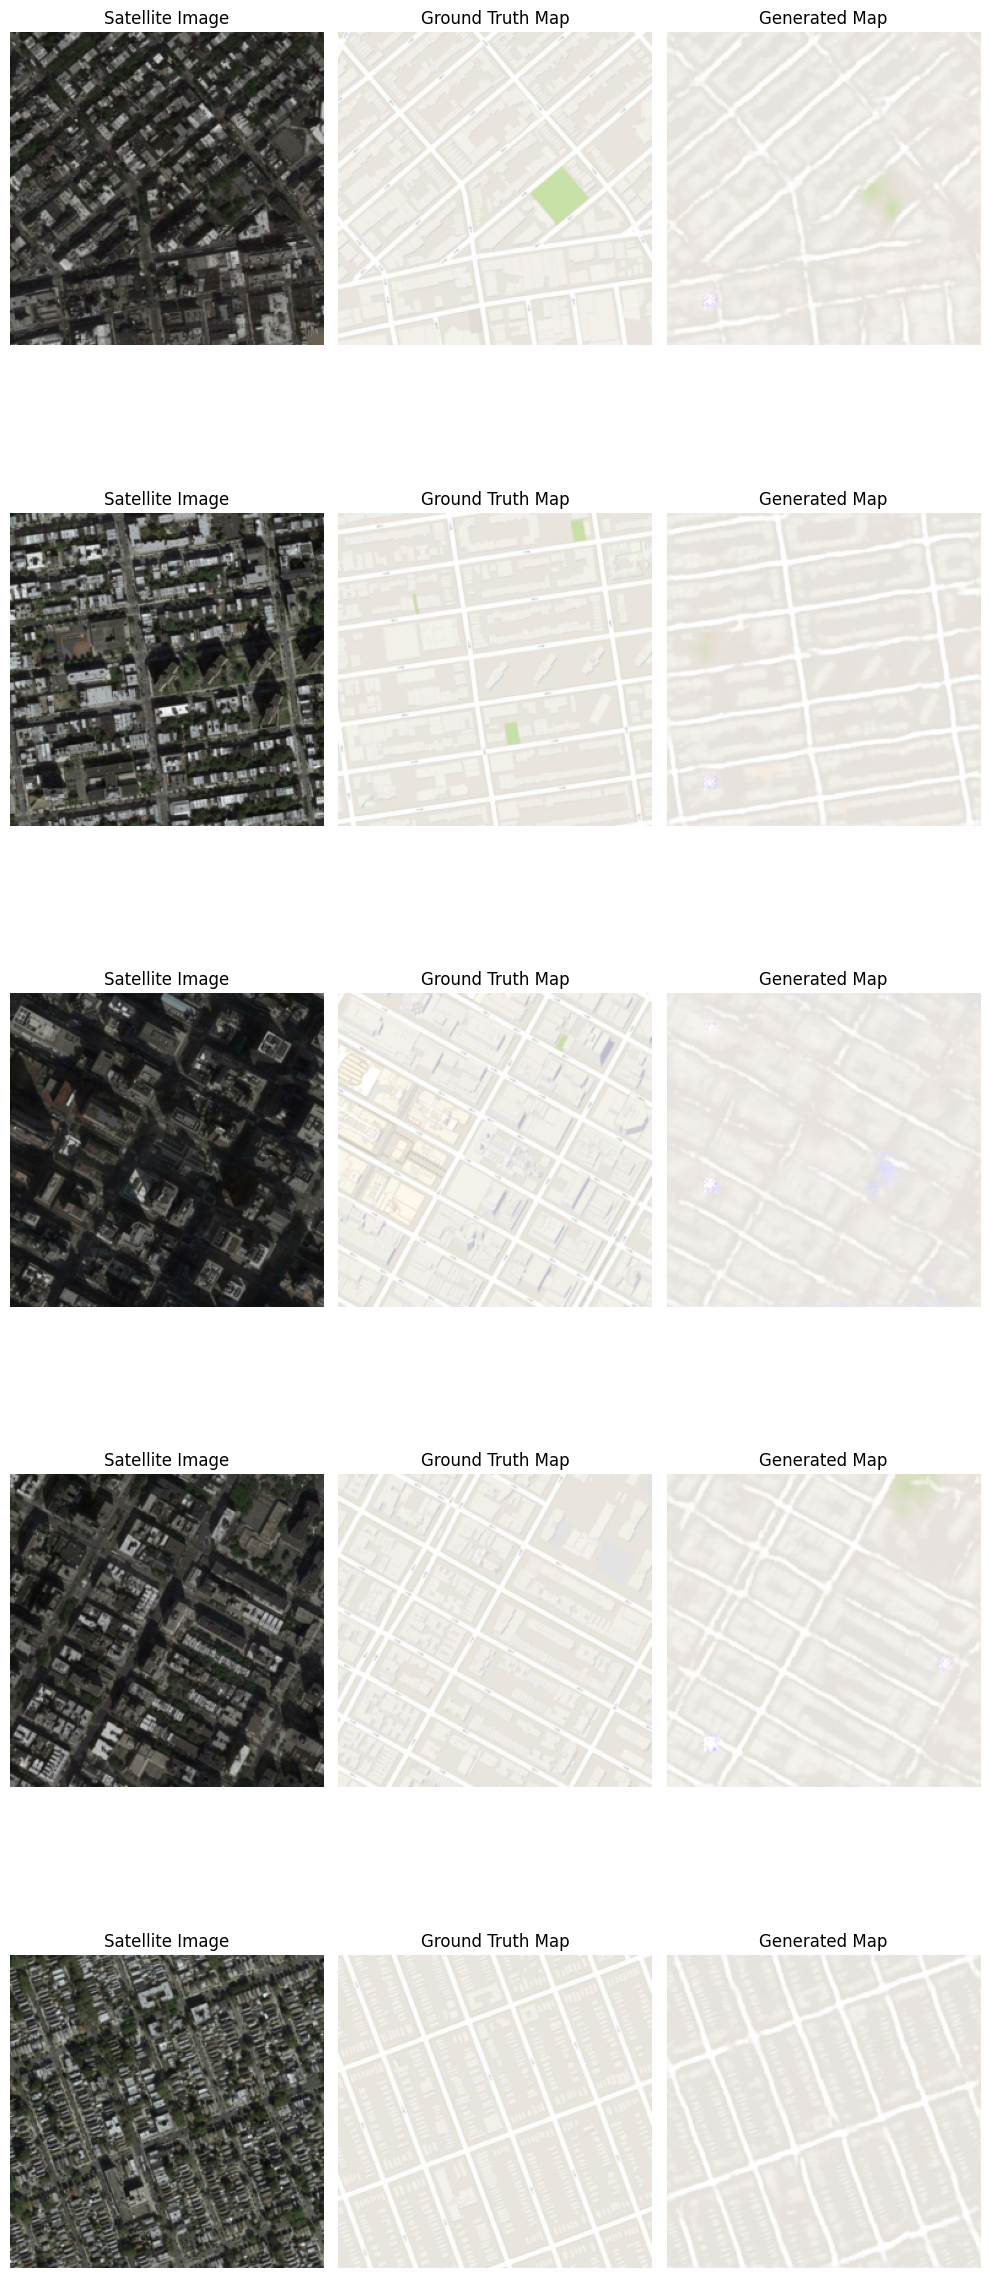

In [ ]:
test_pix2pix(gen, val_dataset, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


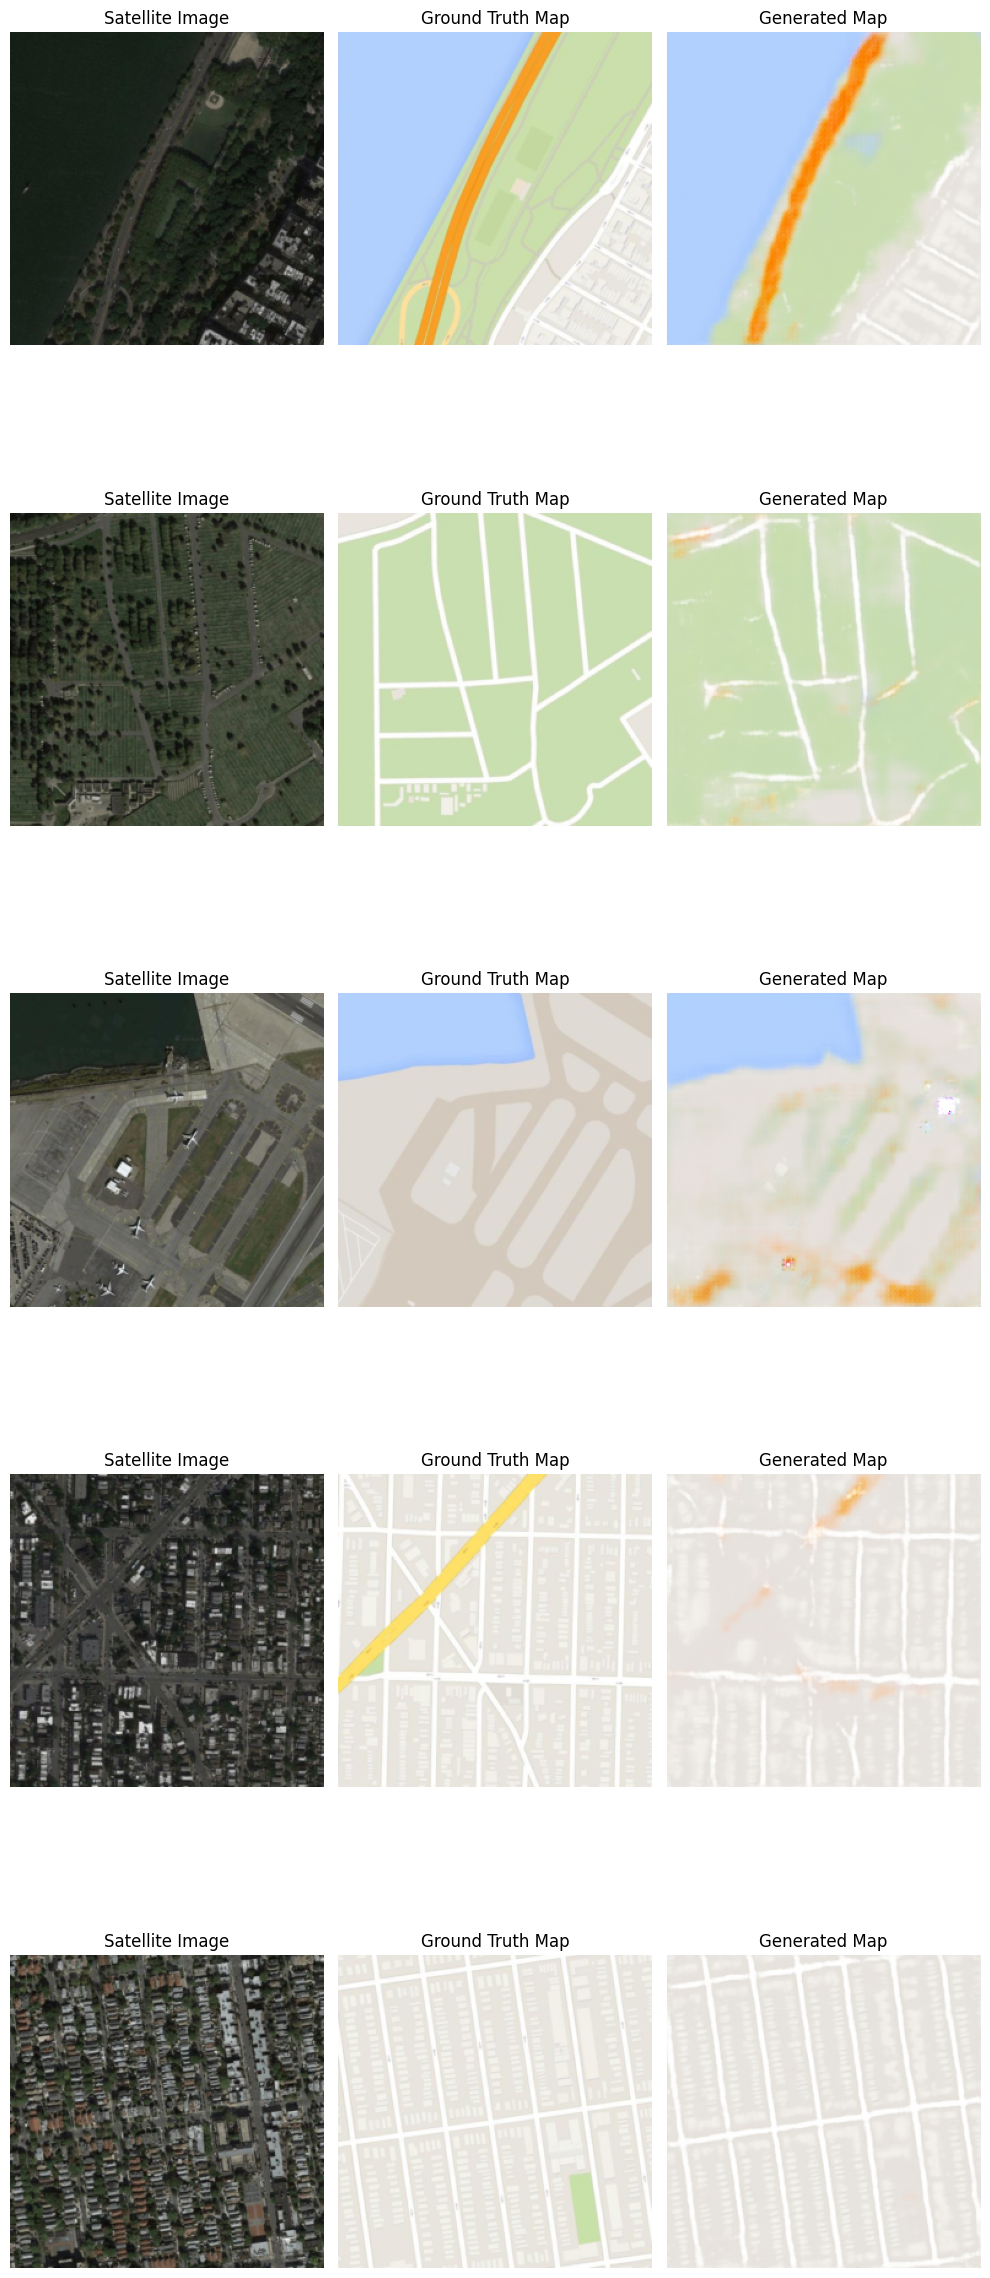

In [ ]:
test_pix2pix(gen, dataset, 5)

In [ ]:
# Save the model after training
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

save_model(pix2pix, "pix2pix_model.pth")

Model saved to /home/ace100/shafiq/NTI/Day 2/pix2pix_model.pth
